In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.animation as animation
from IPython.display import HTML

np.set_printoptions(suppress=True)

import bayesflow as bf
import tensorflow as tf

from functools import partial
from numba import njit

from bayesflow.simulation import Prior, Simulator, GenerativeModel




C:\Users\Gerald Wong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\bayesflow\trainers.py:27: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


# Vicsek model: partial pooling

This notebook provides a baseline, hierarchical estimate for parameters in the Vicsek model.

The model

for any agent $a = 1, ..., A$ with neighbors $i = 1, ..., I$:

\begin{align}
    \theta_{a, t} &= \langle \theta_{i, t}\rangle_{|\mathbf{x}_a - \mathbf{x}_i| < r_a, i \in I} + \eta_{a,t-1}, \\
    \mathrm{d} \mathbf{x}_{a,t} &= v_{a,t} \mathrm{d}t
    \begin{bmatrix}
        \cos \theta_{a, t} \\
        \sin \theta_{a, t}
    \end{bmatrix},
\end{align}

Hyperpriors and priors

\begin{align}
    \alpha_r &\sim \mathcal{U}(1, 5),\\
    \beta_r &\sim \mathcal{U}(1, 5).
\end{align}

\begin{align}
    r_a &\sim \mathrm{Beta}(\alpha_r, \beta_r) \quad \text{for } a = 1,...,A, \\
    v_a &\sim \mathrm{Beta}(2, 2) \quad \text{for } a = 1,...,A
\end{align}

In [30]:
param_names = [r'$\alpha_r$', r'$\beta_r$']

@njit
def hierarchical_prior_fun():
    """
    Sample prior parameters for the agent group, 
    i.e., base scale of sensing radius (r) and walking speed (v). 
    
    Returns
    -------
    Sampled priors as a NumPy array.
    """
    
    alpha_r = np.random.uniform(1., 5.)
    beta_r = np.random.uniform(1., 5.)
    
    return np.array([alpha_r, beta_r], dtype=np.float32)

In [31]:
test_prior = Prior(prior_fun=hierarchical_prior_fun, param_names=param_names)
test_prior(batch_size=2)

{'prior_draws': array([[2.7125907, 2.8051271],
        [3.568726 , 3.697302 ]], dtype=float32),
 'batchable_context': None,
 'non_batchable_context': None}

In [36]:
@njit
def initialize_agents(
    num_agents = 12,
    boundary_size = 10.,
):
    """
    Initialize agent positions and directions.
    
    Parameters
    ----------
    num_agents      : int, default: 12
        Number of agents to initialize. 
    boundary_size   : float, default: 10.0
        Size of the boundary (in meters).
    
    Returns
    -------
    positions      : np.ndarray of shape (num_agents, 2)
        Initial positions of the agents.
    directions      : np.ndarray of shape (num_agents, )
        Initial directions of the agents. 
    """
    
    positions = np.random.random(size=(num_agents, 2)).astype(np.float32) * boundary_size
    directions = np.random.random(size=num_agents) * np.pi

    theta = np.empty((num_agents, 2), dtype=np.float32)
    priors = hierarchical_prior_fun()
    
    # Use hyperpriors to sample conditional priors
    for i in range(num_agents):
        r = np.random.beta(priors[0], priors[1])
        v = np.random.beta(2., 2.)

        theta[i,0] = r
        theta[i,1] = v

    return positions, directions, theta

In [38]:
positions, directions, theta = initialize_agents(num_agents=12, boundary_size=10)

theta

array([[0.8604632 , 0.18502982],
       [0.9103168 , 0.7496304 ],
       [0.5147302 , 0.7324264 ],
       [0.5001174 , 0.37235105],
       [0.19363926, 0.07890095],
       [0.5482139 , 0.44292974],
       [0.13876516, 0.8399942 ],
       [0.68887395, 0.33739012],
       [0.7553057 , 0.47679406],
       [0.10686485, 0.48182192],
       [0.48916993, 0.21834628],
       [0.20812427, 0.9217755 ]], dtype=float32)

In [39]:
@njit
def simulator_fun(
        theta=None,
        num_agents=12,
        num_timesteps=100,
        boundary_size=10.0,
):
    """
    Simulate the movement trajectory of the agent,
    as governed by the Vicsek model.

    Parameters
    ----------
    theta : np.ndarray of shape (2, )
        Sampled priors for the model, including the
        base sensing radius (r) and walking speed (v)
        of the agents.
    num_agents     : int, default: 12
        Number of agents to simulate.
    num_timesteps   : int, default: 100
        Number of timesteps to simulate.
    boundary_size   : float, default: 10.0
        Size of the simulation boundary (in meters).

    Returns
    -------
    A concatenated NumPy array of combined trajectory
    and direction of the agents as timeseries.
    """

    # Initialize positions and directions for each agent
    positions, directions, theta = initialize_agents(num_agents, boundary_size)

    r, v = theta[:, 0], theta[:, 1]

    # Scale radius with half of boundary size (for realism)
    radius = r * boundary_size * 0.5

    # Store trajectories and headings
    paths = np.zeros((num_timesteps + 1, num_agents, 2))
    headings = np.zeros((num_timesteps + 1, num_agents, 1))

    paths[0] = positions
    headings[0] = directions[:, np.newaxis]

    # Loop over each timestep
    for t in range(num_timesteps):
        # For each timestep, initialize directions for the agents
        new_directions = np.zeros(num_agents)

        # For each agent, collect neighbors within its sensing range
        for i in range(num_agents):

            neighbors = []
            # If there are any neighbors, average over their directions
            # and assign it as the new direction.
            for j in range(num_agents):
                if i != j and np.linalg.norm(positions[i] - positions[j]) < radius[i]:
                    neighbors.append(directions[j])
            if neighbors:
                avg_direction = np.mean(np.array(neighbors))
                new_directions[i] = avg_direction + np.random.uniform(-0.01, 0.01)
            else:
                new_directions[i] = directions[i]

        directions = np.copy(new_directions)

        # Update position upon new direction
        positions[:, 0] += v * np.cos(directions)
        positions[:, 1] += v * np.sin(directions)

        # Assumes periodic boundary condition (for now)
        positions = np.mod(positions, boundary_size)

        # Add timestamps to trajectories and headings
        paths[t + 1] = np.copy(positions)
        headings[t + 1] = np.copy(directions[:, np.newaxis])

    return np.concatenate((paths, headings), axis=-1)

Querying the simulated results directly to the prior samples.

In [40]:
check_priors = hierarchical_prior_fun()

check_simulator = simulator_fun()
check_simulator

array([[[2.00811535, 7.13403583, 1.31933155],
        [6.91274285, 4.99081403, 0.05104014],
        [5.00893235, 3.90828162, 2.11739729],
        ...,
        [1.41553193, 0.78454427, 2.82830682],
        [5.04460633, 0.2529956 , 1.05509097],
        [9.69959319, 0.06012035, 2.4435083 ]],

       [[1.84622033, 7.78124592, 1.81590949],
        [7.15070723, 5.70278765, 1.24823717],
        [5.56803536, 4.4811276 , 0.79753855],
        ...,
        [1.07639403, 0.89440947, 2.82830682],
        [5.33049003, 0.75731241, 1.05509097],
        [9.32069534, 0.37802282, 2.4435083 ]],

       [[2.02358688, 8.42438821, 1.30170399],
        [7.13180086, 6.4532382 , 1.59598436],
        [5.879195  , 5.21864259, 1.17155196],
        ...,
        [0.73725613, 1.00427466, 2.82830682],
        [5.34798756, 1.33675937, 1.54060856],
        [8.94179749, 0.6959253 , 2.4435083 ]],

       ...,

       [[2.12790643, 6.48649   , 2.54545213],
        [0.91931146, 9.47932252, 2.54981052],
        [7.31080814, 1

In [10]:
check_priors

array([2.3145638, 3.157848 ], dtype=float32)

In [61]:
average_heading = np.mean(check_simulator[:,:,-1], axis=1)
global_average_heading = np.mean(average_heading)
global_average_heading

0.6062963525704615

In [41]:
sns.lineplot(data=average_heading)

NameError: name 'average_heading' is not defined

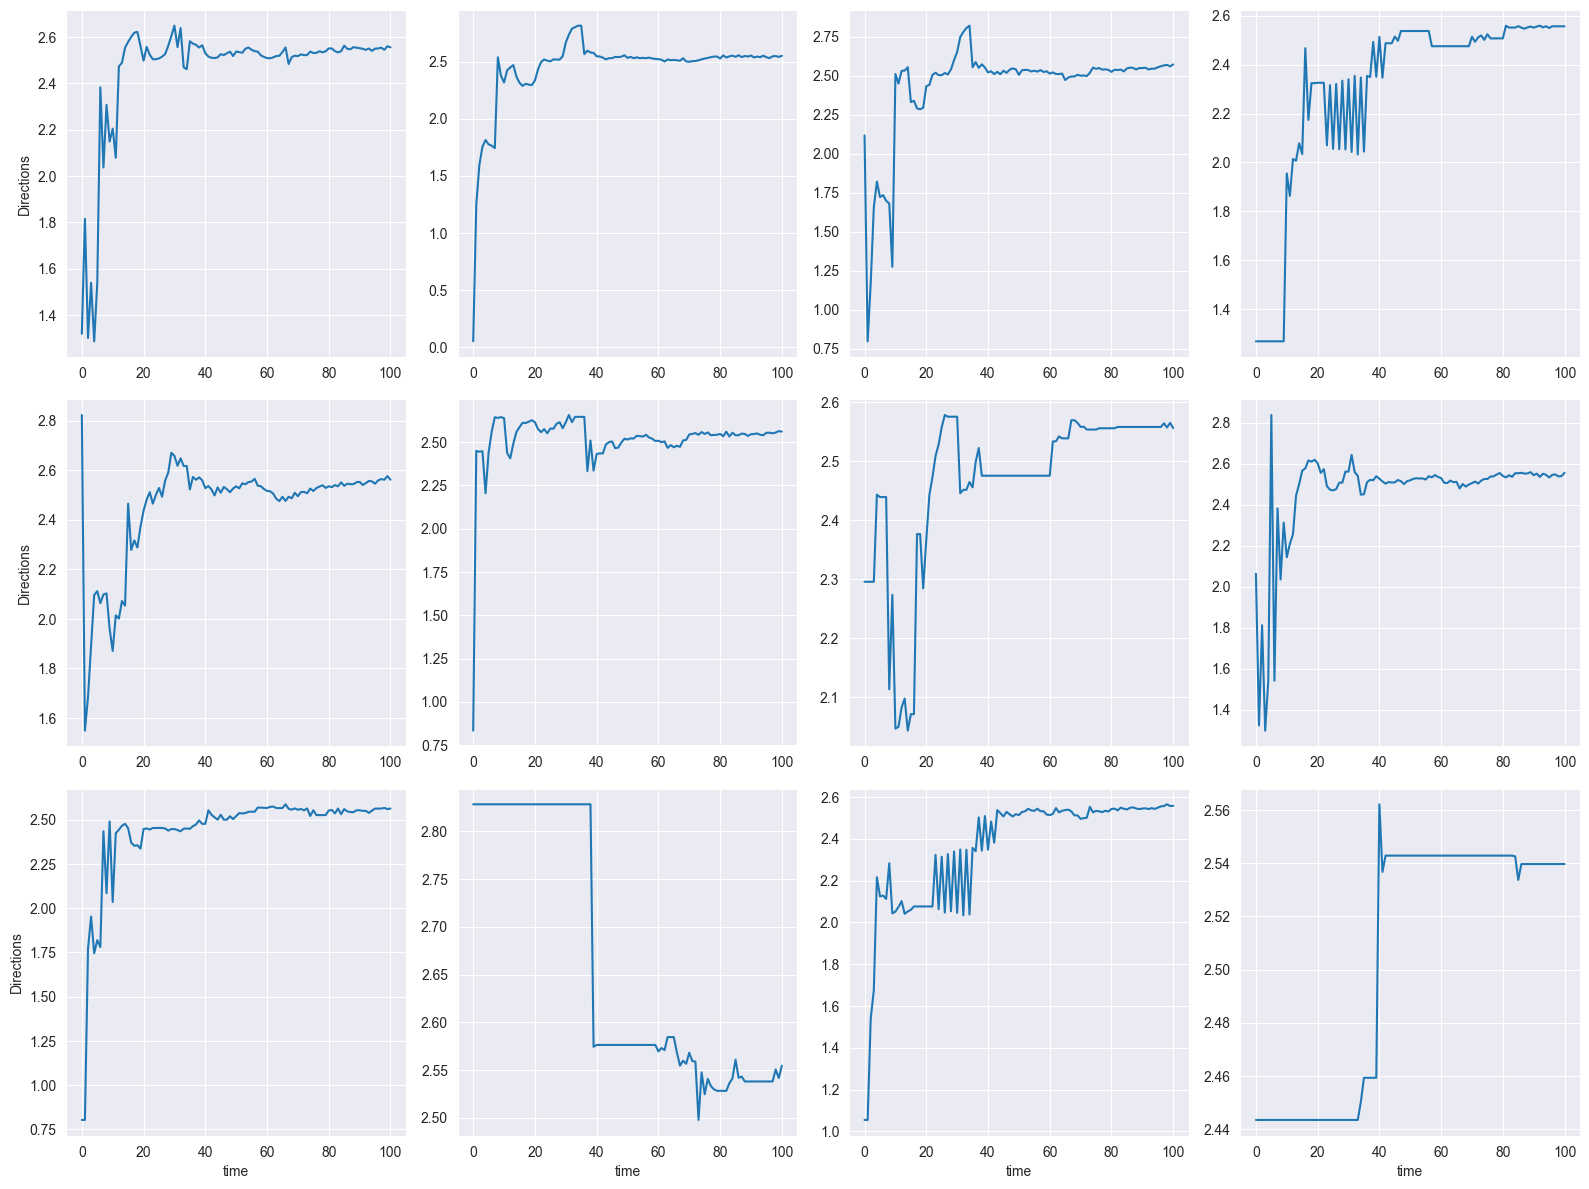

In [42]:
fig, axarr = plt.subplots(3, 4, figsize=(16, 12))

for i, ax in enumerate(axarr.flat):
    sns.lineplot(check_simulator[:,i,-1], ax=ax)
    
    if i >= 8:
        ax.set_xlabel("time")
    if i % 4 == 0:
        ax.set_ylabel("Directions")
    
fig.tight_layout()

# Generative Model

In [11]:
prior = Prior(prior_fun=prior_fun)

simulator = Simulator(simulator_fun=simulator_fun)

model = GenerativeModel(prior=prior, simulator=simulator, simulator_is_batched=False, name="Vicsek")

INFO:root:Performing 2 pilot runs with the Vicsek model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 2)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 101, 12, 3)
INFO:root:No optional prior non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional simulation batchable context provided.


In [12]:
def animate(paths, boundary_size = 10.0):
    
    positions = paths[:,:,0:2]
    directions = paths[:,:,2:]
    
    fig, ax = plt.subplots(figsize=(4, 4))


    def update(frame):
        ax.clear()
        quiver = ax.quiver(positions[frame, :, 0], positions[frame, :, 1], np.cos(directions[frame]), np.sin(directions[frame]))
        quiver.set_offsets(positions[frame])
        quiver.set_UVC(np.cos(directions[frame]), np.sin(directions[frame]))
        ax.set_xlim(0, boundary_size)
        ax.set_ylim(0, boundary_size)
        return quiver,

    a = animation.FuncAnimation(fig, update, frames=len(positions), blit=True, repeat=False)
    plt.title("Vicsek Model")
    plt.xlabel("X")
    plt.ylabel("Y")
    
    return a

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.HTMLWriter'>
INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.HTMLWriter'>
INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.HTMLWriter'>
INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.HTMLWriter'>


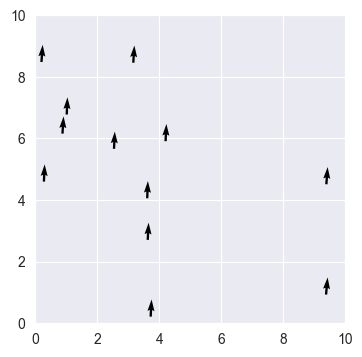

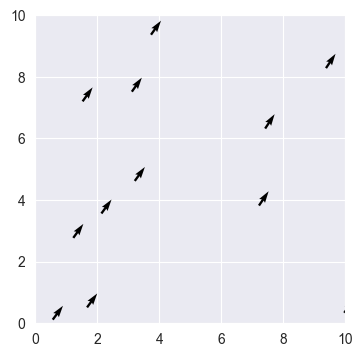

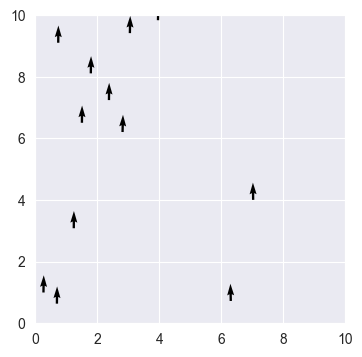

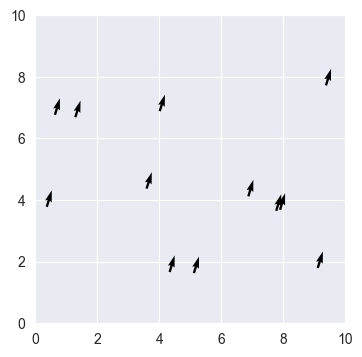

In [13]:
pushforward_sim = model(4)['sim_data']

for i in range(pushforward_sim.shape[0]):
    a = animate(pushforward_sim[i])
    m = HTML(a.to_jshtml())

# Configurator

In [14]:
def configurator(input_dict: dict = None, transpose: bool = True):
    
    output_dict = {}
    output_dict['parameters'] = input_dict['prior_draws'].astype(np.float32)
    x = input_dict['sim_data'] / 10. 
    if transpose:
        x = np.transpose(x, (0, 2, 1, 3))
    output_dict['summary_conditions'] = x.astype(np.float32)
    return output_dict

In [15]:
# class StackedLSTM(tf.keras.Model):
#     def __init__(self, summary_dim=32, lstm_units=512, hidden_units=512, dropout=0.05):
#         super().__init__()
        
#         self.mlp = tf.keras.Sequential([
#             tf.keras.layers.Dense(hidden_units, activation="mish"),
#             tf.keras.layers.Dropout(dropout),
#             tf.keras.layers.Dense(hidden_units // 16)
#         ])
#         self.lstm = tf.keras.layers.LSTM(lstm_units, dropout=dropout)
#         self.projector = tf.keras.layers.Dense(summary_dim)
        
#     def call(self, x, **kwargs):
        
#         old_shape = tf.shape(x)
#         x = tf.reshape(x, shape=(old_shape[0], old_shape[1], -1))
#         embeddings = self.mlp(x, **kwargs)
#         rep = self.lstm(embeddings, **kwargs)
#         proj = self.projector(rep)
#         return proj

# Neural Approximator

In [17]:
# This one generalizes over different numbers of agents
summary_net = bf.summary_networks.HierarchicalNetwork([
    tf.keras.layers.TimeDistributed(tf.keras.layers.LSTM(units=128)),
    bf.networks.SetTransformer(num_inducing_points=None, input_dim=128, summary_dim=64)
])

In [18]:
inference_net = bf.inference_networks.InvertibleNetwork(
    num_params=2, 
    num_coupling_layers=5,
    coupling_design="affine",
    coupling_settings={
        'kernel_regularizer': None,
        'dropout_prob': 0.0
    }
)


amortizer = bf.amortizers.AmortizedPosterior(
    summary_net=summary_net, 
    inference_net=inference_net
)


trainer = bf.trainers.Trainer(
    amortizer=amortizer,
    generative_model=model,
    configurator=configurator
)

INFO:root:Performing a consistency check with provided components...
INFO:root:Done.


# Online Training

In [19]:
history = trainer.train_online(epochs=10, batch_size=32, iterations_per_epoch=500)

Training epoch 1:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 2:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 3:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 4:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 5:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 6:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 7:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 8:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 9:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 10:   0%|          | 0/500 [00:00<?, ?it/s]

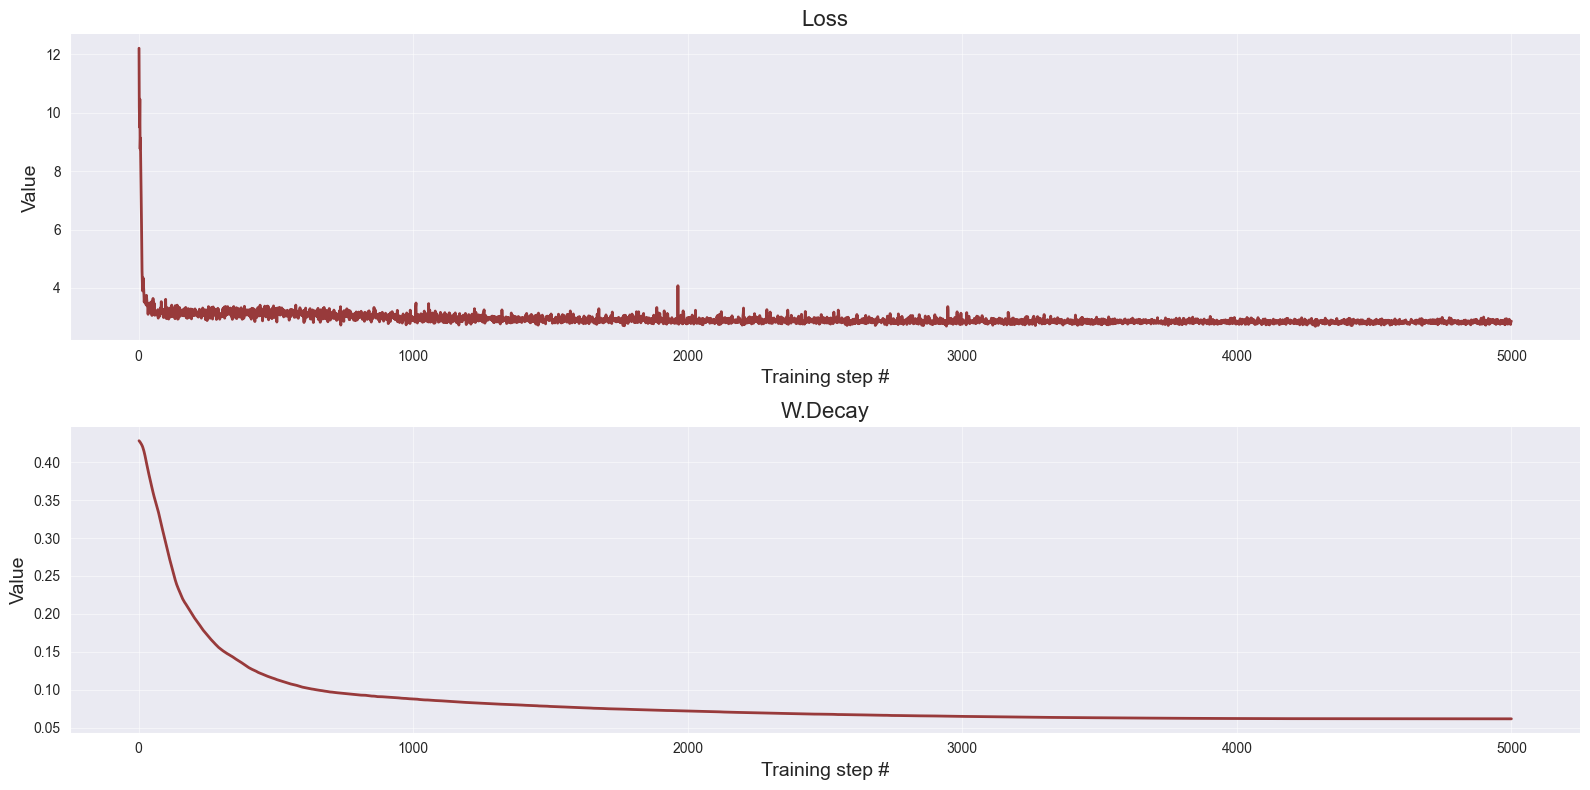

In [20]:
f = bf.diagnostics.plot_losses(history)

# Validation

In [21]:
validation_sim = model(400)
validation_configured = configurator(validation_sim)

In [22]:
post_samples = amortizer.sample(validation_configured, n_samples=1000)
prior_samples = validation_configured["parameters"]

# Parameter Recovery

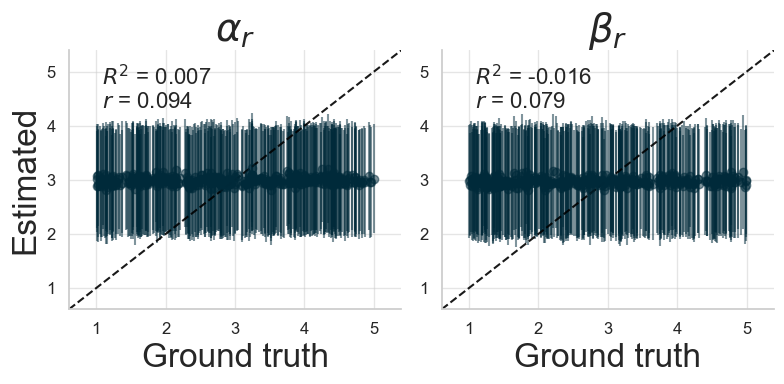

In [43]:
sns.set(rc={'axes.facecolor':'#FFFFFF00', 'figure.facecolor':'#FFFFFF00'})
sns.set_style('whitegrid')

g = bf.diagnostics.plot_recovery(
    post_samples=post_samples, 
    prior_samples=prior_samples, 
    param_names=param_names,
    label_fontsize=24,
    title_fontsize=28,
    color="#002a3a"
)

The drift $v$ shows near-perfect recovery, followed by the noise parameter $\eta$.

INFO:root:The ratio of simulations / posterior draws should be > 20 for reliable variance reduction, but your ratio is 0.                    Confidence intervals might be unreliable!


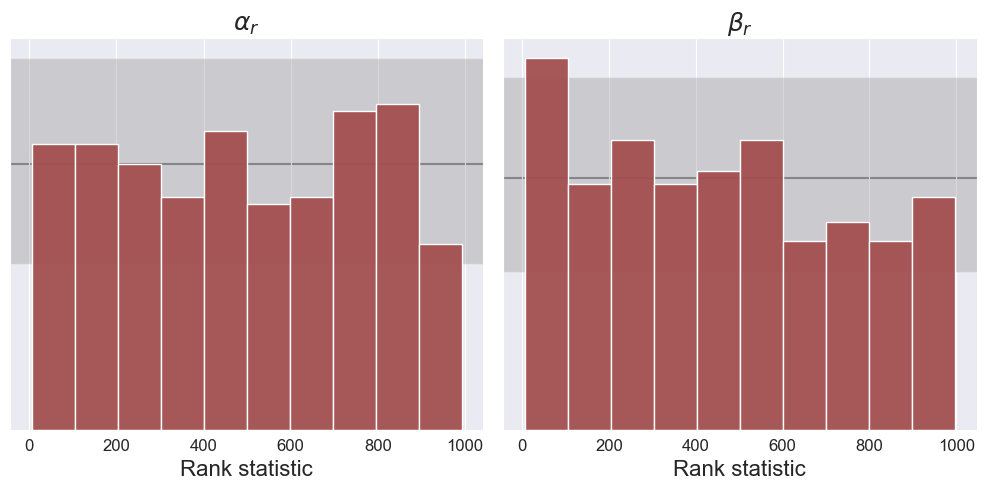

In [24]:
h = bf.diagnostics.plot_sbc_histograms(post_samples=post_samples, prior_samples=prior_samples, param_names=param_names, num_bins=10)

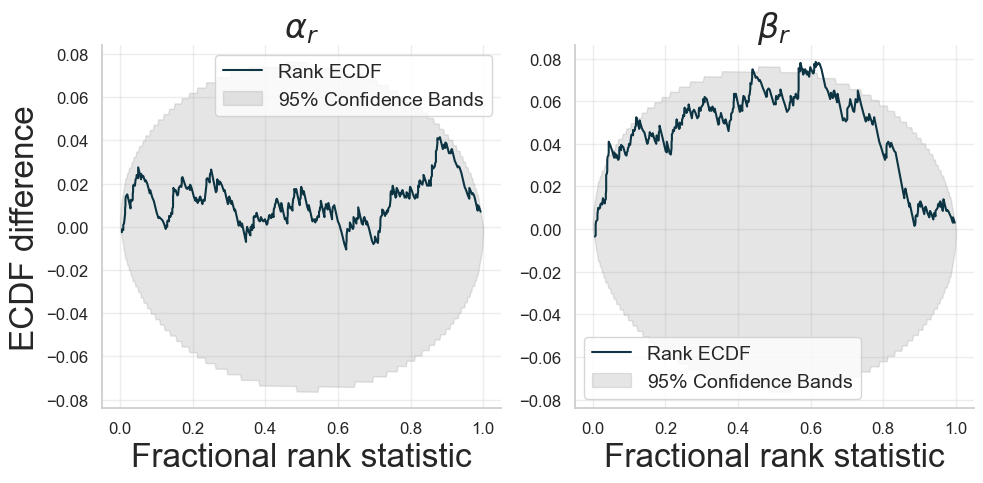

In [44]:
e = bf.diagnostics.plot_sbc_ecdf(
    post_samples=post_samples, 
    prior_samples=prior_samples, 
    param_names=param_names, 
    difference=True,
    label_fontsize=24,
    title_fontsize=24,
    rank_ecdf_color="#002a3a"
)

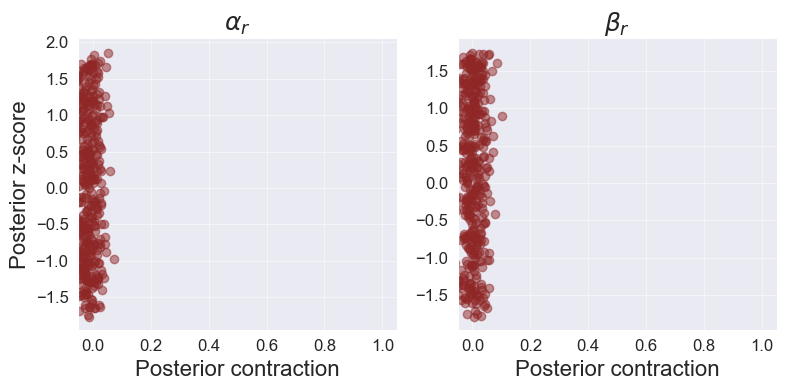

In [26]:
c = bf.diagnostics.plot_z_score_contraction(post_samples=post_samples, prior_samples=prior_samples, param_names=param_names)

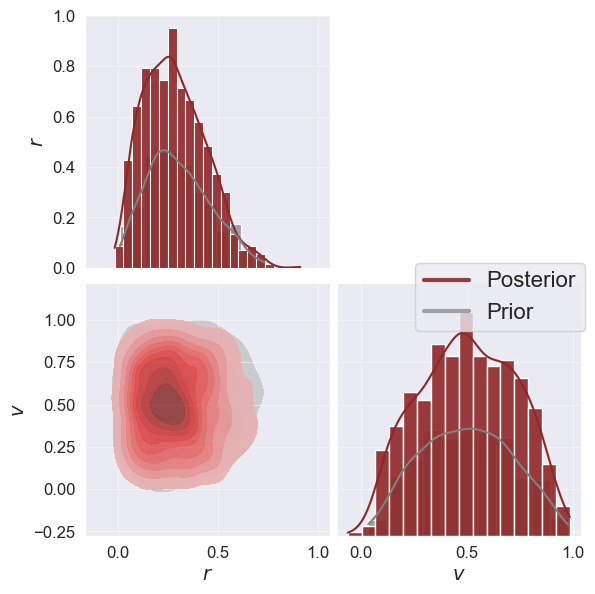

In [26]:
d = bf.diagnostics.plot_posterior_2d(posterior_draws=post_samples[1], prior_draws=prior_samples, param_names=param_names)